In [1]:
%matplotlib inline

# Essentials: Data Cleansing and ETL
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerLine2D

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc # good for evaluation of binary classification problems
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('nflData.csv', sep=",")

C:\Users\RICHARDSONLG20\AppData\Local\Temp\ipykernel_11512\104963401.py:1: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nflData.csv', sep=",")


In [3]:
print("Rows: ",len(df))

Rows:  449371


In [4]:
# Get average results for offensive plays by game for model
# to preserve the dataframe's shape (with GameID being unique), I'm going to use a split-apply-merge strategy

# Split - from origional DF: Get 2 DF's for plays that are labeled Run or Pass
r_off_agg = df[(df.play_type == 'run')]
p_off_agg = df[(df.play_type == 'pass')]

# Apply - groupby aggregation to find the Median yards by game, team, PlayType, and qtr
r_off_agg = r_off_agg.groupby(['game_id','qtr','posteam'])['ydsnet'].mean().reset_index()
p_off_agg = p_off_agg.groupby(['game_id','qtr','posteam'])['ydsnet'].mean().reset_index()

r_off_agg = r_off_agg.rename(columns={'ydsnet':'rushing_mean'}) # Rename the columns for clarity
p_off_agg = p_off_agg.rename(columns={'ydsnet':'passing_mean'})

# Merge - Combine the Away and Home averages into one dataframe
off_agg = pd.merge(r_off_agg,
                 p_off_agg,
                 left_on=['game_id','qtr','posteam'],
                 right_on=['game_id','qtr','posteam'],
                 how='outer')

off_agg.head(10)

,game_id,qtr,posteam,rushing_mean,passing_mean
0,2009091000,1,PIT,3.833333,5.375000
1,2009091000,1,TEN,26.666667,35.555556
2,2009091000,2,PIT,26.750000,24.625000
3,2009091000,2,TEN,24.400000,35.307692
4,2009091000,3,PIT,7.625000,7.500000
5,2009091000,3,TEN,14.222222,23.666667
6,2009091000,4,PIT,55.000000,29.750000
7,2009091000,4,TEN,9.400000,22.750000
8,2009091000,5,PIT,21.500000,29.285714
9,2009091300,1,ATL,20.500000,19.600000


In [5]:
# add data regarding offensive stats
df = pd.merge(df,
                off_agg,
                left_on=['game_id','qtr','posteam'],
                right_on=['game_id','qtr','posteam'],
                how='left')

In [6]:
# take the dataframe for plays above and define particular columns we want
play_attr = ['game_id','qtr','game_seconds_remaining','yardline_100','ydstogo','drive','down','play_type','goal_to_go',
             'posteam','defteam','posteam_score', 'defteam_score', 'score_differential','posteam_timeouts_remaining','no_score_prob',
             'opp_fg_prob','opp_safety_prob','home_team', 'rushing_mean', 'passing_mean']
plays = df[play_attr]

df = df[(df.play_type == "run")|(df.play_type=="pass")]

In [7]:

# pos team is home team
plays['Home'] = plays.apply(lambda x: 1 if x.home_team == x.posteam else 0, axis=1)


plays['play_type'] = plays.apply(lambda x: 1 if x.play_type == "pass" else 0, axis=1)

# Up by 2 scores bool
plays['UpByTwoScoresBool'] = plays.apply(lambda x: 1 if x.score_differential > 8 else 0, axis=1)

# Up by 3 scores bool
plays['UpByThreeScoresBool'] = plays.apply(lambda x: 1 if x.score_differential > 16 else 0, axis=1)



In [8]:
# need to clean float data and transfer to integer
plays.game_seconds_remaining = plays.game_seconds_remaining.fillna(0).astype(int)
plays.yardline_100 = plays.yardline_100.fillna(0).astype(int)
plays.down = plays.down.fillna(0).astype(int)
plays.posteam_score = plays.posteam_score.fillna(0).astype(int)
plays.defteam_score = plays.defteam_score.fillna(0).astype(int)
plays.rushing_mean = plays.rushing_mean.fillna(0).astype(int)
plays.passing_mean = plays.passing_mean.fillna(0).astype(int)
plays.score_differential = plays.score_differential.fillna(0).astype(int)
plays.goal_to_go = plays.goal_to_go.fillna(0).astype(int)

In [9]:
# changing float64 to float32
plays.no_score_prob = plays.no_score_prob.fillna(0).astype(np.float32)
plays.opp_fg_prob = plays.opp_fg_prob.fillna(0).astype(np.float32)
plays.opp_safety_prob = plays.opp_safety_prob.fillna(0).astype(np.float32)


plays.no_score_prob = pd.qcut(plays['no_score_prob'], 5, labels=False)
plays.opp_fg_prob = pd.qcut(plays['opp_fg_prob'], 5, labels=False)
plays.opp_safety_prob = pd.qcut(plays['opp_safety_prob'], 5, labels=False)

In [10]:
# drop unneeded columns to begin to de-clutter the set
plays = plays[plays.down != 0]
plays = plays.drop(columns=['home_team'])

plays.head(5)

,game_id,qtr,game_seconds_remaining,yardline_100,ydstogo,drive,down,play_type,goal_to_go,posteam,...,score_differential,posteam_timeouts_remaining,no_score_prob,opp_fg_prob,opp_safety_prob,rushing_mean,passing_mean,Home,UpByTwoScoresBool,UpByThreeScoresBool
1,2009091000,1,3593,58,10,1,1,1,0,PIT,...,0,3.0,0,3,2,3,5,1,0,0
2,2009091000,1,3556,53,5,1,2,0,0,PIT,...,0,3.0,0,2,2,3,5,1,0,0
3,2009091000,1,3515,56,8,1,3,1,0,PIT,...,0,3.0,0,3,3,3,5,1,0,0
4,2009091000,1,3507,56,8,1,4,0,0,PIT,...,0,3.0,1,4,3,3,5,1,0,0
5,2009091000,1,3496,98,10,2,1,0,0,TEN,...,0,3.0,1,4,4,26,35,0,0,0


In [11]:
plays.dropna(inplace=True)

In [12]:
# TODO: add back defteam

plays = plays.reset_index()

# Define our prediction data
plays_predictors = [ 'UpByTwoScoresBool','UpByTwoScoresBool',
'game_id','qtr','game_seconds_remaining','yardline_100',
'ydstogo','drive','down', 'goal_to_go','posteam_score', 'defteam_score', 
'score_differential','posteam_timeouts_remaining',
'no_score_prob','opp_fg_prob','opp_safety_prob', 'rushing_mean', 'passing_mean', 'Home',]


# plays_predictors = [
# 'game_id','qtr','game_seconds_remaining','yardline_100', 'ydstogo','drive','down', 'goal_to_go', 'posteam_score', 'defteam_score']


X = plays[plays_predictors]

# Define the prediction target: PlayType
y = plays.play_type

In [13]:
# Split our data into training and test data for both our target and prediction data sets
# random state = 0 means we get same result everytime if we want to change later
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [14]:
# print(np.any(np.isnan(train_x)))
# print(np.all(np.isfinite(train_x)))


# Decision Tree Classifier
desc_tree = DecisionTreeClassifier()
desc_tree.fit(train_X, train_y)

dt_predictions = desc_tree.predict(val_X)

print(dt_predictions[:10])

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, dt_predictions)
dt_roc_auc = auc(false_positive_rate, true_positive_rate)

[0 0 0 1 1 1 1 1 0 0]


In [15]:
print(dt_roc_auc)

0.6319202745082002


In [16]:
for i in range(1000, 1010):
    p = "pass"
    if dt_predictions[i] == 0:
        p = "run"
    actual = "pass"
    check = "✔️"
    if plays.iloc[i]["play_type"] == 0:
        actual = "run"
    if p != actual:
        check = "❌"
    print(f"Play: {plays.iloc[i]}\n\nPrediction: {p.upper()}\tActual: {actual.upper()}\t{check}\n\n")


Play: index                               1167
game_id                       2009091303
qtr                                    4
game_seconds_remaining               218
yardline_100                          67
ydstogo                               10
drive                                 20
down                                   1
play_type                              0
goal_to_go                             0
posteam                              CIN
defteam                              DEN
posteam_score                          0
defteam_score                          6
score_differential                    -6
posteam_timeouts_remaining           3.0
no_score_prob                          4
opp_fg_prob                            2
opp_safety_prob                        2
rushing_mean                          38
passing_mean                          36
Home                                   1
UpByTwoScoresBool                      0
UpByThreeScoresBool                    0
Name: 1000

<AxesSubplot:xlabel='feature'>

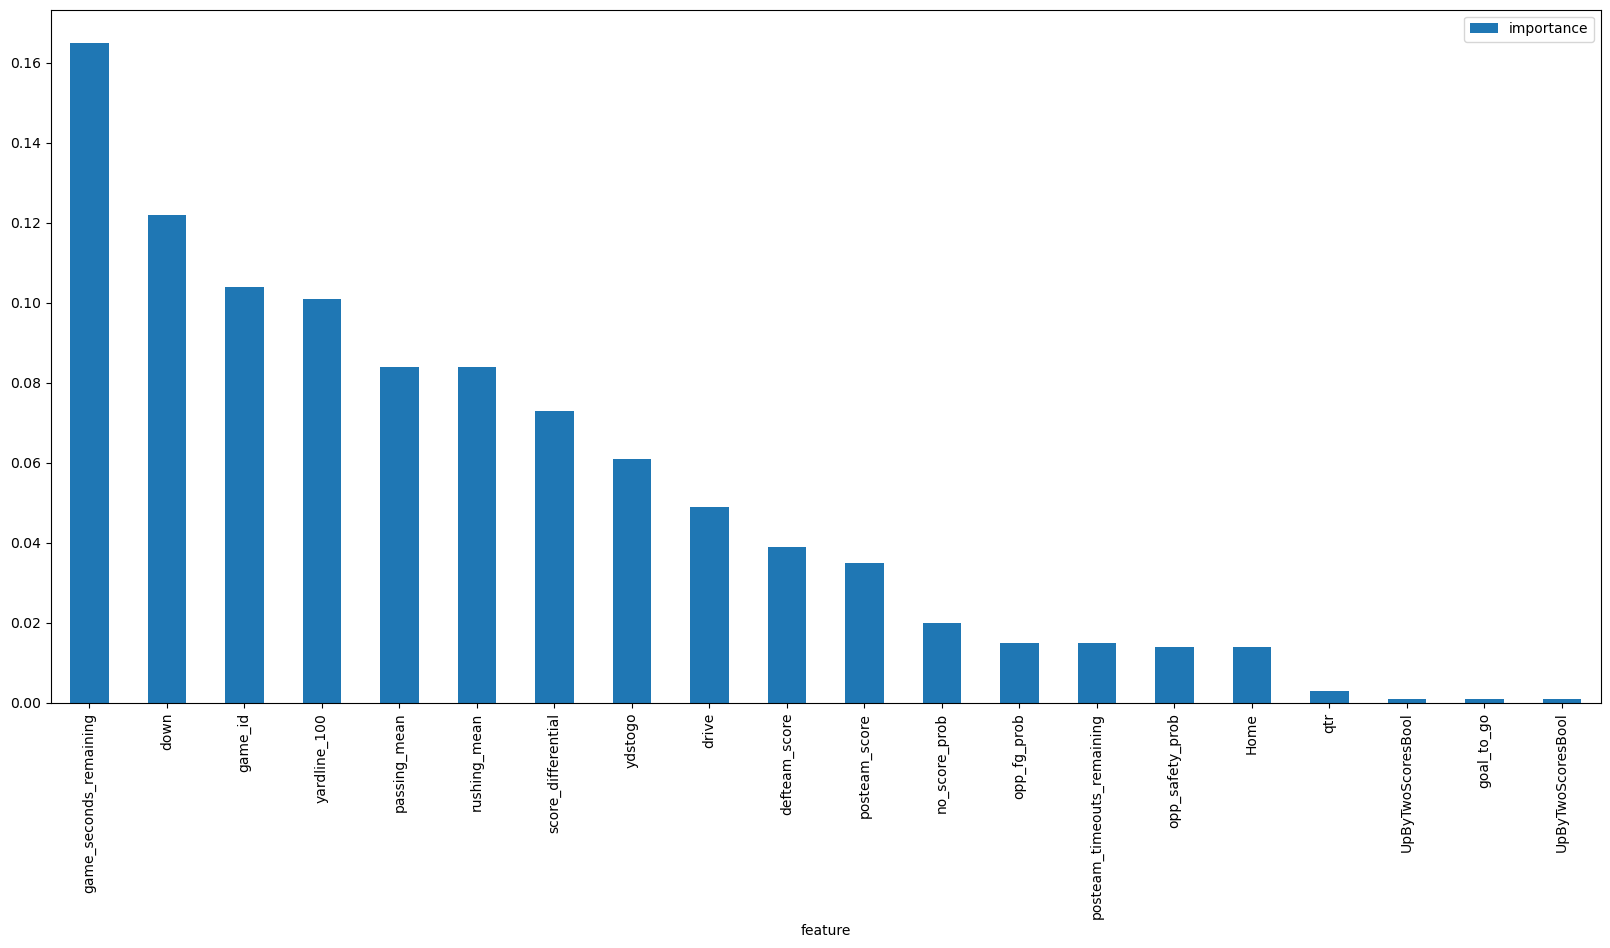

In [17]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(desc_tree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(20,9),rot=90)

In [18]:
def acc(predicted, actual):
    correct = 0

    for i in range(len(actual)-1):
        if (predicted[i] == actual.iloc[i]):
            correct+=1
    print(f"Accuracy: {(correct/len(actual))*100}%")
    
acc(dt_predictions, val_y)

Accuracy: 63.21166810172837%
